بسم الله 

** Importing liberies and frameworks **

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Load videos and Preprocessing : ** defines a function load_video that takes a path to a video file as input and returns a preprocessed version of the video frames as a list of TensorFlow tensors lets eplain this with a simple graphe *

Test the function (LOad_video)

In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

**Extracts information from files, and compiles a vocabulary list**

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [5]:
vocab=np.unique(get_vocab())

In [6]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


> Create a Mapping layers for preprocessing using tensorflow Stringlookup :tf.keras.layers.StringLookup

In [7]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

> char_to_num StringLookup Layer:
> 
> tf.keras.layers.StringLookup is used to create a layer that maps characters to numerical indices.
> The vocabulary parameter is set to your vocab, which is the list of characters obtained from your get_vocab function.
> oov_token stands for "out-of-vocabulary" token and is set to an empty string (""). This token is used for unseen characters during inference.
> num_to_char StringLookup Layer:
> 
> Another StringLookup layer is created to map numerical indices back to characters.
> The vocabulary parameter is set to the vocabulary obtained from the char_to_num layer using char_to_num.get_vocabulary().
> oov_token is also set to an empty string (""), and invert is set to True, indicating that this layer should perform an inverse mapping.

> *After convert the alignments to a num (Conversion to Numerical Indices) ---> reshape the tensor to one dim tensor*

In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [9]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [10]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [11]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

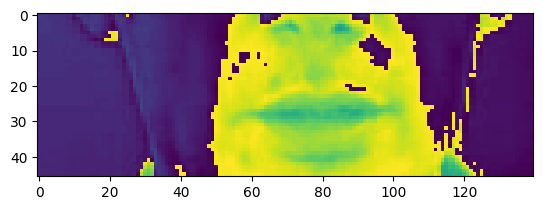

In [12]:
plt.imshow(frames[15])

**
Sets up a TensorFlow data pipeline for loading lipreading data from video file**

In [13]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [14]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [15]:
frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[[1.3511412 ],
          [1.3125372 ],
          [0.84928876],
          ...,
          [0.3088323 ],
          [0.3088323 ],
          [0.3088323 ]],

         [[1.119517  ],
          [1.2739332 ],
          [0.81068474],
          ...,
          [0.3088323 ],
          [0.3088323 ],
          [0.3088323 ]],

         [[1.5827655 ],
          [1.5827655 ],
          [1.2739332 ],
          ...,
          [0.3088323 ],
          [0.27022824],
          [0.27022824]],

         ...,

         [[1.158121  ],
          [1.080913  ],
          [1.080913  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.080913  ],
          [1.080913  ],
          [1.080913  ],
          ...,
          [9.844028  ],
          [9.844028  ],
          [9.844028  ]],

         [[1.080913  ],
          [1.080913  ],
          [1.080913  ],
          ...,
          [9.844028  ],
          [9.844028  ],
          [9.844028  ]]],


        [[[1.3511

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [20]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [22]:
yhat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [23]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
history = model.fit(train, validation_data=test, epochs=40, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/40
420/450 [===========================>..] - ETA: 29s - loss: 84.6206

[mpeg1video @ 0x7d7c0c65d080] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c0c65d080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 83.9315

[mpeg1video @ 0x7d7dec11b4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dec11b4c0] Warning MVs not available
[mpeg1video @ 0x7d7de80b9000] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7de80b9000] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: binhiteithuthreeagain
Prediction: leee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhiteintoneagain
Prediction: leee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 924s 2s/step - loss: 83.9315 - val_loss: 71.4769 - lr: 1.0000e-04
Epoch 2/40
142/450 [========>.....................] - ETA: 4:52 - loss: 73.5182

[mpeg1video @ 0x7d7de8072f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7de8072f00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 71.8857

[mpeg1video @ 0x7d7c0cb991c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c0cb991c0] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: layredithsoneagain
Prediction: laeeeen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binbluebyfnineagain
Prediction: laeeeen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 678s 2s/step - loss: 71.8857 - val_loss: 65.6478 - lr: 1.0000e-04
Epoch 3/40
364/450 [=======================>......] - ETA: 1:22 - loss: 67.9731

[mpeg1video @ 0x7d7d240469c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7d240469c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 67.5883

[mpeg1video @ 0x5a8bdb5e3e80] ac-tex damaged at 22 17
[mpeg1video @ 0x5a8bdb5e3e80] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: placeredinponesoon
Prediction: laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatzsixplease
Prediction: laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 674s 1s/step - loss: 67.5883 - val_loss: 62.6469 - lr: 1.0000e-04
Epoch 4/40
416/450 [==========================>...] - ETA: 32s - loss: 64.7453

[mpeg1video @ 0x7d7c647fc7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c647fc7c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.6048

[mpeg1video @ 0x7d7ddc0acc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7ddc0acc40] Warning MVs not available


1/1 [==============================] - 0s 194ms/step
Original: laygreeninrninesoon
Prediction: laeeeen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binbluebyzninesoon
Prediction: laeeeen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 668s 1s/step - loss: 64.6048 - val_loss: 60.7059 - lr: 1.0000e-04
Epoch 5/40
112/450 [======>.......................] - ETA: 5:19 - loss: 63.0995

[mpeg1video @ 0x7d77b918ccc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77b918ccc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.2615

[mpeg1video @ 0x7d7c88069340] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c88069340] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: layredatysixplease
Prediction: laeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenatuoneagain
Prediction: laeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 671s 1s/step - loss: 62.2615 - val_loss: 59.1975 - lr: 1.0000e-04
Epoch 6/40
171/450 [==========>...................] - ETA: 4:24 - loss: 61.0859

[mpeg1video @ 0x7d787c0bdc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d787c0bdc40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.0793

[mpeg1video @ 0x7d7c64022880] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c64022880] Warning MVs not available


1/1 [==============================] - 0s 194ms/step
Original: layhiteinlzeroplease
Prediction: lareteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehitebykthreeagain
Prediction: lareteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 672s 1s/step - loss: 59.0793 - val_loss: 53.9874 - lr: 1.0000e-04
Epoch 7/40
342/450 [=====================>........] - ETA: 1:42 - loss: 56.2134

[mpeg1video @ 0x5a8bdc759c00] ac-tex damaged at 22 17
[mpeg1video @ 0x5a8bdc759c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 55.9483

[mpeg1video @ 0x7d7c14c9cb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c14c9cb00] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: placehiteatdtono
Prediction: lareteeao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredspbygtono
Prediction: lareteeao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 669s 1s/step - loss: 55.9483 - val_loss: 52.4871 - lr: 1.0000e-04
Epoch 8/40
184/450 [===========>..................] - ETA: 4:09 - loss: 55.0484

[mpeg1video @ 0x7d7d2406c700] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7d2406c700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 54.7990

[mpeg1video @ 0x7d787407e640] ac-tex damaged at 22 17
[mpeg1video @ 0x7d787407e640] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: placegreenindfivesoon
Prediction: lareeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredithosevensoon
Prediction: lareeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 666s 1s/step - loss: 54.7990 - val_loss: 51.2985 - lr: 1.0000e-04
Epoch 9/40
275/450 [=================>............] - ETA: 2:44 - loss: 53.4198

[mpeg1video @ 0x7d7c8004eb80] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c8004eb80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 52.9838

[mpeg1video @ 0x7d7dec0b0900] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dec0b0900] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: setblueingsixplease
Prediction: lareeaon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatytoplease
Prediction: lareeean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 663s 1s/step - loss: 52.9838 - val_loss: 50.6123 - lr: 1.0000e-04
Epoch 10/40
318/450 [====================>.........] - ETA: 2:04 - loss: 51.1734

[mpeg1video @ 0x7d7c28091840] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c28091840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.1180

[mpeg1video @ 0x7d7dd802b7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dd802b7c0] Warning MVs not available


1/1 [==============================] - 0s 200ms/step
Original: setredatufiveagain
Prediction: plareieean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueinfoneagain
Prediction: lareieean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 51.1180 - val_loss: 47.2084 - lr: 1.0000e-04
Epoch 11/40
450/450 [==============================] - ETA: 0s - loss: 49.7584

[mpeg1video @ 0x7d7c70083380] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c70083380] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: binblueithseightno
Prediction: lareteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueinzzerono
Prediction: laretoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 663s 1s/step - loss: 49.7584 - val_loss: 46.8242 - lr: 1.0000e-04
Epoch 12/40
148/450 [========>.....................] - ETA: 4:41 - loss: 48.1460

[mpeg1video @ 0x7d786c05d480] ac-tex damaged at 22 17
[mpeg1video @ 0x7d786c05d480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 47.9553

[mpeg1video @ 0x7d7c1c0aa980] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c1c0aa980] Warning MVs not available


1/1 [==============================] - 0s 191ms/step
Original: bingreenithheightno
Prediction: blareioo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenithdonesoon
Prediction: placreiieson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 660s 1s/step - loss: 47.9553 - val_loss: 44.4858 - lr: 1.0000e-04
Epoch 13/40
189/450 [===========>..................] - ETA: 4:04 - loss: 46.2497

[mpeg1video @ 0x7d7dd80c0c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dd80c0c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 45.8179

[mpeg1video @ 0x7d77da728a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77da728a80] Warning MVs not available


1/1 [==============================] - 0s 192ms/step
Original: binhitebytsixno
Prediction: slareino
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredininineagain
Prediction: laretiean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 45.8179 - val_loss: 40.9628 - lr: 1.0000e-04
Epoch 14/40
450/450 [==============================] - ETA: 0s - loss: 43.7703

[mpeg1video @ 0x7d7dec882540] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dec882540] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: laygreenatznineagain
Prediction: lareiieaon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueithhsixno
Prediction: lacbluebeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 43.7703 - val_loss: 39.0213 - lr: 1.0000e-04
Epoch 15/40
 85/450 [====>.........................] - ETA: 5:39 - loss: 42.3867

[mpeg1video @ 0x7d7c7007e800] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c7007e800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 41.4994

[mpeg1video @ 0x7d7dcc208440] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dcc208440] Warning MVs not available


1/1 [==============================] - 0s 192ms/step
Original: layhitebyzsevenagain
Prediction: lareiieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhitebyafourno
Prediction: laretoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 41.4994 - val_loss: 36.8738 - lr: 1.0000e-04
Epoch 16/40
450/450 [==============================] - ETA: 0s - loss: 39.2876

[mpeg1video @ 0x7d7c7802b700] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c7802b700] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: placehitebyxeightno
Prediction: placreiio
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatsthreeagain
Prediction: blablueiieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 39.2876 - val_loss: 34.7521 - lr: 1.0000e-04
Epoch 17/40
  3/450 [..............................] - ETA: 6:49 - loss: 38.0660

[mpeg1video @ 0x7d7c04077840] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c04077840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 37.2944

[mpeg1video @ 0x7d7c647b7bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c647b7bc0] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: binredatsnineagain
Prediction: senreitieagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredbygthreesoon
Prediction: setrebyseson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 661s 1s/step - loss: 37.2944 - val_loss: 32.6172 - lr: 1.0000e-04
Epoch 18/40
337/450 [=====================>........] - ETA: 1:46 - loss: 35.0719

[mpeg1video @ 0x7d7ddc029140] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7ddc029140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.0462

[mpeg1video @ 0x7d77b919c7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77b919c7c0] Warning MVs not available


1/1 [==============================] - 0s 191ms/step
Original: setredithvzerono
Prediction: setreitrono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueithbfiveagain
Prediction: bitblueiieagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 664s 1s/step - loss: 35.0462 - val_loss: 28.3699 - lr: 1.0000e-04
Epoch 19/40
 47/450 [==>...........................] - ETA: 6:12 - loss: 32.8282

[mpeg1video @ 0x7d7d24073580] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7d24073580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 32.6014

[mpeg1video @ 0x7d787c487dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d787c487dc0] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: layredinktono
Prediction: laygreioo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placebluebyvsixno
Prediction: placebluebyiono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 663s 1s/step - loss: 32.6014 - val_loss: 27.5684 - lr: 1.0000e-04
Epoch 20/40
338/450 [=====================>........] - ETA: 1:45 - loss: 30.4961

[mpeg1video @ 0x7d7c78033340] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c78033340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.3797

[mpeg1video @ 0x7d7de81da240] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7de81da240] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: layblueatqsevenagain
Prediction: layblueatieagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreeninczeroplease
Prediction: peaegrennorplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 665s 1s/step - loss: 30.3797 - val_loss: 24.1934 - lr: 1.0000e-04
Epoch 21/40
237/450 [==============>...............] - ETA: 3:19 - loss: 28.3049

[mpeg1video @ 0x7d77b8d600c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77b8d600c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.3566

[mpeg1video @ 0x7d7c80050500] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c80050500] Warning MVs not available


1/1 [==============================] - 0s 191ms/step
Original: sethiteinhnineagain
Prediction: sethiteitieagin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layblueithefourno
Prediction: laybluebyono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 661s 1s/step - loss: 28.3566 - val_loss: 22.9992 - lr: 1.0000e-04
Epoch 22/40
 16/450 [>.............................] - ETA: 6:39 - loss: 26.3704

[mpeg1video @ 0x7d7c04001380] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c04001380] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 26.2252

[mpeg1video @ 0x7d7c5c830f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c5c830f40] Warning MVs not available


1/1 [==============================] - 0s 197ms/step
Original: layredbyzoneagain
Prediction: layredbyoeaon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreeninithreesoon
Prediction: setgreninireson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 661s 1s/step - loss: 26.2252 - val_loss: 20.6356 - lr: 1.0000e-04
Epoch 23/40
 82/450 [====>.........................] - ETA: 5:40 - loss: 24.3146

[mpeg1video @ 0x7d7de4105440] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7de4105440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 24.2732

[mpeg1video @ 0x7d7c28053ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c28053ac0] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: bingreenbynninesoon
Prediction: bingrenbyneson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethitebyczerono
Prediction: sethitebyorno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 660s 1s/step - loss: 24.2732 - val_loss: 19.3396 - lr: 1.0000e-04
Epoch 24/40
271/450 [=================>............] - ETA: 2:47 - loss: 22.3912

[mpeg1video @ 0x7d7dcc037800] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dcc037800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.4108

[mpeg1video @ 0x7d787404a9c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d787404a9c0] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: layhiteinesevenagain
Prediction: layhiteitneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredatmthreesoon
Prediction: binrediteson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 663s 1s/step - loss: 22.4108 - val_loss: 17.1946 - lr: 1.0000e-04
Epoch 25/40
294/450 [==================>...........] - ETA: 2:26 - loss: 21.2834

[mpeg1video @ 0x7d7c840d4480] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c840d4480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 21.2630

[mpeg1video @ 0x7d7ddc0c9040] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7ddc0c9040] Warning MVs not available


1/1 [==============================] - 0s 191ms/step
Original: placeredithdfourno
Prediction: placereditforno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeblueatifivesoon
Prediction: placeblueaifiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 661s 1s/step - loss: 21.2630 - val_loss: 16.1081 - lr: 1.0000e-04
Epoch 26/40
 32/450 [=>............................] - ETA: 6:27 - loss: 19.7704

[mpeg1video @ 0x7d7c5cb7c440] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7c5cb7c440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.5692

[mpeg1video @ 0x7d7dcc02cc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7dcc02cc40] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: placehiteithytono
Prediction: placehiteitono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatythreeagain
Prediction: placegrenattreagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 19.5692 - val_loss: 14.9541 - lr: 1.0000e-04
Epoch 27/40
 31/450 [=>............................] - ETA: 6:30 - loss: 18.2769

In [ ]:


# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the model in the native Keras format
from tensorflow.keras.models import save_model
save_model(model, 'models/my_model.keras')


In [ ]:
الحمد الله 